In [58]:
import math, os
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product
from autograd.extend import primitive, defvjp
import meep as mp
import meep.adjoint as mpa
from meep.materials import Ag
import matplotlib.pyplot as plt
import nlopt

mp.verbosity(0)
resolution = 50      # px/µm

lambda0 = 0.5            # [um]
fcen    = 1.0 / lambda0  # [1/um]
width = 0.1
fwidth = fcen*width

nfreq   = 1
frequencies = [fcen]

dpml = 0.5
dair = 1.0
hrod = 0.5     

dsub = 1.0
dAg  = 0.25

sx = 2.121                          # +-3차가 +-45도 나옴
sx = 2.828                          # +-4차가 +-45도 나옴
sy = dpml + dair + hrod + dsub + dAg + dpml
cell_size = mp.Vector3(sx, sy)

wrod = sx

Medium1 = mp.Medium(index = 2.0)
Medium2 = mp.Medium(index = 1.0)

pml_layers = [
    mp.PML(direction=mp.Y, thickness=dpml, side=mp.High),
    mp.PML(direction=mp.Y, thickness=dpml, side=mp.Low)
]

@primitive
def layer_division_2d_autodiff(x_flat, num_layer, Nx, Ny):
    """
    x_flat: (Nx*Ny,) 1D 디자인 벡터
    y 방향으로 num_layer 개로 나누어, 각 레이어 내부를 y축 평균값으로 평탄화함.
    """
    X2 = x_flat.reshape(Nx, Ny)
    Xout = npa.zeros_like(X2)

    # 레이어 높이 계산 (픽셀 단위)
    # 균일하게 나누기 위해 linspace 사용 후 정수로 변환
    layer_boundaries = np.linspace(0, Ny, num_layer + 1).astype(int)

    for i in range(num_layer):
        s, e = layer_boundaries[i], layer_boundaries[i+1]
        if s == e: continue # 혹시라도 해상도가 너무 낮을 경우 대비

        # 해당 레이어 구간 추출 (Nx, thickness)
        seg = X2[:, s:e]
        
        # y축 방향 평균 계산 -> (Nx, 1)
        m = npa.mean(seg, axis=1, keepdims=True)

        # 평균값을 해당 레이어 전체에 브로드캐스팅
        Xout[:, s:e] = npa.broadcast_to(m, seg.shape)

    return Xout.reshape(-1)

def _ld2d_vjp(ans, x_flat, num_layer, Nx, Ny):
    """
    VJP: 레이어 평균화(Mean) 연산의 역전파
    Forward에서 평균을 취했으므로, Backward에서는 Gradient를 
    레이어 픽셀 수(n_elem)로 나누어 분배함.
    """
    def vjp(g_flat):
        g2 = g_flat.reshape(Nx, Ny)
        gout = npa.zeros_like(g2)

        layer_boundaries = np.linspace(0, Ny, num_layer + 1).astype(int)

        for i in range(num_layer):
            s, e = layer_boundaries[i], layer_boundaries[i+1]
            if s == e: continue

            gseg = g2[:, s:e]
            n_elem = float(e - s) # 레이어의 두께(픽셀 수)
            
            # 해당 레이어의 Gradient 합계 계산
            gsum = npa.sum(gseg, axis=1, keepdims=True)

            # Gradient를 입력 픽셀들에 균등 분배
            gout[:, s:e] = npa.broadcast_to(gsum / n_elem, gseg.shape)

        return gout.reshape(-1)

    return vjp

# VJP 등록
defvjp(
    layer_division_2d_autodiff,
    lambda ans, x, num, nx, ny: _ld2d_vjp(ans, x, num, nx, ny),
    argnums=[0] # x_flat에 대해서만 미분
)

DESIGN_W  = wrod
DESIGN_H  = hrod
design_c  = mp.Vector3(0, 0.5*sy - dpml - dAg - dsub - 0.5*hrod)
design_sz = mp.Vector3(DESIGN_W, DESIGN_H)


design_res = resolution
NX = int(DESIGN_W * design_res) + 1

DESIGN_MODE = 'free'  # or 'free' or 'grating'

if DESIGN_MODE == 'free':
    NY = int(round(DESIGN_H * design_res)) + 1
else:
    # 해상도와 레이어-패딩 조건을 동시에 만족
    DESIRED_LAYERS = 4       # 원하는 레이어 수 (패딩 1픽셀씩 자동)
    NY_min_layers = 2 * DESIRED_LAYERS - 1        # 레이어 L개 + 패딩 L-1개
    NY_res       = int(round(DESIGN_H * design_res))
    NY = max(NY_res, NY_min_layers)

n_vars = NX * NY

# 최소 피쳐/이진화 설정
MIN_FEATURE = 0.09    # ~80 nm
eta_i = 0.55
filter_radius = mpa.get_conic_radius_from_eta_e(MIN_FEATURE, eta_i)

# x = np.ones((n_vars,), dtype=float) * 0.5
np.random.seed(42)

x = np.random.rand(n_vars) * 0.2 + 0.4
# x = np.ones(n_vars)*0.5

design_vars = mp.MaterialGrid(
    mp.Vector3(NX, NY, 0),
    Medium1, Medium2,
    grid_type="U_MEAN",
)
design_region = mpa.DesignRegion(design_vars, volume=mp.Volume(center=design_c, size=design_sz))

# ----------------------------
# geometry (디자인 포함)
# ----------------------------
geometry = [
    mp.Block(
        material=Ag,
        center=mp.Vector3(0, 0.5*sy - dpml - 0.5*dAg),
        size=mp.Vector3(mp.inf, dAg, mp.inf),
    ),
    # Medium1 bulk (Ag 아래에 위치)
    mp.Block(
        material=Medium1,
        center=mp.Vector3(0, 0.5*sy - dpml - dAg - 0.5*dsub),
        size=mp.Vector3(mp.inf, dsub, mp.inf),
    ),
    # Design block (텍스처 영역)
    mp.Block(
        material=design_vars,
        center=design_region.center,
        size=design_region.size,
    ),
]

bottom_pml_top_y = -0.5 * sy + dpml
src_center = mp.Vector3(0, bottom_pml_top_y + (3 / resolution))
src_size   = mp.Vector3(sx, 0, 0)

sources = [
    mp.Source(
        mp.GaussianSource(frequency=fcen, fwidth=fwidth),
        component=mp.Ez,
        center=mp.Vector3(0, src_center.y),
        size=mp.Vector3(sx, 0)
    )
]

##### 공정 가능한 구조 설계시 #####
def grating_mapping(x, eta, beta):
    global DESIRED_LAYERS

    X = layer_division_2d_autodiff(
            x.ravel(), DESIRED_LAYERS, NX, NY
    )    
    X_2D = X.reshape(NX,NY)
    X_symmetry = 0.5 * (npa.flipud(X_2D) + X_2D)                 # <- 좌우 대칭
    X_projection = mpa.tanh_projection(X_symmetry, beta=beta, eta=eta)
    return X_projection.ravel()


##### 완전한 자유형상 설계시 #####
def free_mapping(x, eta, beta):
    filt = mpa.conic_filter(x, filter_radius, DESIGN_W, DESIGN_H, design_res)   # (NY, NX)
    filt = (npa.flipud(filt) + filt) / 2
    projected_field = mpa.tanh_projection(filt, beta, eta)

    return projected_field.flatten()

##### Mode 선택 #####
mapping = free_mapping if DESIGN_MODE == 'free' else grating_mapping

sim = mp.Simulation(
    cell_size=cell_size,
    resolution=resolution,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    k_point = mp.Vector3(0,0,0),
    extra_materials=[Ag],
    default_material=mp.Medium(index=1),
)

# --- FourierFields 모니터 (y=0.7 선) ---
ff_center = mp.Vector3(0, 0.7, 0)
ff_size   = mp.Vector3(sx, 0, 0)
ff_vol    = mp.Volume(center=ff_center, size=ff_size)

ff_Ez = mpa.FourierFields(sim, volume=ff_vol, component=mp.Ez)
# -----------------------------------------
# 1) DFT 모니터 설치 (ff_Ez와 동일한 위치/길이)
# -----------------------------------------
dft_line = sim.add_dft_fields([mp.Ez], fcen, 0, 1, center=ff_center, size=ff_size)


margin = 0.4  # [um] 디자인 하단 바로 아래로 살짝 내림

# --- FourierFields 모니터 (y=0.7 선) ---
ff_center = mp.Vector3(0, 0.7, 0)
ff_size   = mp.Vector3(sx, 0, 0)
ff_vol    = mp.Volume(center=ff_center, size=ff_size)

ff_Ez = mpa.FourierFields(sim, volume=ff_vol, component=mp.Ez)

# --- k_x vector 추가 보정 ---
margin = 0.4  # [um] 디자인 하단 바로 아래로 살짝 내림

# 디자인 하단 y좌표
design_bottom_y = design_region.center.y - 0.5 * design_region.size.y

# 추가 모니터의 중심과 크기 (x는 주기 전체 길이)
ff_center_below = mp.Vector3(0, design_bottom_y - margin, 0)
ff_size_below   = mp.Vector3(sx, 0, 0)
ff_vol_below    = mp.Volume(center=ff_center_below, size=ff_size_below)

ff_check_Ez = mpa.FourierFields(sim, volume=ff_vol_below, component=mp.Ez)

# ------------------------------------------------------------
# 단일-bin 인덱스 캐시 (N, m_order가 같으면 항상 같은 bin을 봄)
# ------------------------------------------------------------
_SINGLEBIN_INDEX_CACHE = {}

def _get_singlebin_indices_order(N, m_order):
    """
    FFTSHIFT(FFT(Ez)) 기준으로 회절차수 bin을 '정확히' 고정해서 반환.
    - 0차: i0 = N//2
    - +m차: i0 + m_order
    - -m차: i0 - m_order (필요 시 사용)
    """
    key = (int(N), int(m_order))
    if key in _SINGLEBIN_INDEX_CACHE:
        return _SINGLEBIN_INDEX_CACHE[key]

    i0 = int(N // 2)
    idx_0  = i0
    idx_p  = i0 + int(m_order)
    idx_m  = i0 - int(m_order)

    # 인덱스 범위 체크 (혹시 N이 너무 작으면 방어)
    if not (0 <= idx_m < N and 0 <= idx_0 < N and 0 <= idx_p < N):
        raise ValueError(f"FFT bin index out of range: N={N}, m_order={m_order}")

    _SINGLEBIN_INDEX_CACHE[key] = (idx_0, idx_p, idx_m)
    return idx_0, idx_p, idx_m


def J_kx(Ez_top_line):
    eps = 1e-25
    m_order = 4
    T0, Tp = 0.6, 0.2

    # -----------------------------
    # 1) 입력 Ez 1D
    # -----------------------------
    Ez = npa.ravel(Ez_top_line)

    N_expected = int(round(sx * resolution))
    if Ez.size == N_expected + 1:
        Ez = Ez[:-1]

    N = int(Ez.size)

    # -----------------------------
    # 2) Etgt 합성 (네 정의 유지)
    # -----------------------------
    dx = sx / N
    x = dx * npa.arange(N)

    C0_t = math.sqrt(0.6)
    Cp_t = math.sqrt(0.2)
    Cm_t = math.sqrt(0.2)

    Etgt = (C0_t
            + Cp_t * npa.exp( 1j * 2.0 * npa.pi * m_order * x / sx)
            + Cm_t * npa.exp(-1j * 2.0 * npa.pi * m_order * x / sx))

    # -----------------------------
    # 3) mode overlap (DC 포함 full overlap)
    # -----------------------------
    Fz = npa.fft.fft(Ez)
    Ft = npa.fft.fft(Etgt)

    inner_k = (dx / N) * npa.sum(npa.conj(Ft) * Fz)
    Ez_e2_k = (dx / N) * npa.sum(npa.abs(Fz) ** 2)
    Et_e2_k = (dx / N) * npa.sum(npa.abs(Ft) ** 2)

    J_ov = (npa.abs(inner_k) ** 2) / ((Ez_e2_k + eps) * (Et_e2_k + eps))  # [0,1]

    # =========================================================
    # 4) 단일 bin FFT score (argmin 제거: 완전 고정 인덱스)
    # =========================================================
    idx_0, idx_p4, _ = _get_singlebin_indices_order(N, m_order)

    F = npa.fft.fftshift(npa.fft.fft(Ez))
    P = npa.abs(F) ** 2
    P = P / (npa.sum(P) + eps)  # 합=1

    P0 = P[idx_0]     # 0차 단일 bin
    Pp = P[idx_p4]    # +4차 단일 bin (네가 원한 단일 bin)

    S = P0 + 2.0 * Pp

    # 목표 비율과의 차이(로그 비율)
    ratio_err = npa.log((P0 + eps) / (Pp + eps)) - npa.log(T0 / Tp)

    # 0~1 매핑
    ratio_score = 1.0 / (1.0 + ratio_err ** 2)

    J_fft = ratio_score * S

    # -----------------------------
    # 5) 최종 목적함수 (maximize)
    # -----------------------------
    def harmonic(x, y):
        return 2*x*y/(x+y)
    # J = harmonic(J_ov, J_fft)
    J = J_ov*J_fft
    return J

def smoothmax(x, alpha=80.0, eps=1e-25):
    """
    differentiable max approximation:
      max(x) ~ (1/alpha) * log(sum(exp(alpha*x)))
    alpha가 클수록 max에 더 가까워짐.
    """
    # overflow 방지: x_max 빼고 exp
    x_max = npa.max(x)
    return (1.0 / alpha) * (npa.log(npa.sum(npa.exp(alpha * (x - x_max))) + eps) + alpha * x_max)


def J_kx(Ez_top_line):
    eps = 1e-25
    m_order = 4
    T0, Tp = 0.6, 0.2

    # -----------------------------
    # 1) 입력 Ez 1D
    # -----------------------------
    Ez = npa.ravel(Ez_top_line)

    N_expected = int(round(sx * resolution))
    if Ez.size == N_expected + 1:
        Ez = Ez[:-1]
    N = int(Ez.size)

    # -----------------------------
    # 2) Etgt 합성
    # -----------------------------
    dx = sx / N
    x = dx * npa.arange(N)

    C0_t = math.sqrt(0.6)
    Cp_t = math.sqrt(0.2)
    Cm_t = math.sqrt(0.2)

    Etgt = (C0_t
            + Cp_t * npa.exp( 1j * 2.0 * npa.pi * m_order * x / sx)
            + Cm_t * npa.exp(-1j * 2.0 * npa.pi * m_order * x / sx))

    # -----------------------------
    # 3) overlap (Parseval-정합, FFT 기반)
    # -----------------------------
    Fz = npa.fft.fft(Ez)
    Ft = npa.fft.fft(Etgt)

    inner_k = (dx / N) * npa.sum(npa.conj(Ft) * Fz)
    Ez_e2_k = (dx / N) * npa.sum(npa.abs(Fz) ** 2)
    Et_e2_k = (dx / N) * npa.sum(npa.abs(Ft) ** 2)

    J_ov = (npa.abs(inner_k) ** 2) / ((Ez_e2_k + eps) * (Et_e2_k + eps))  # [0,1]

    # -----------------------------
    # 4) FFT power (sum=1)
    # -----------------------------
    idx_0, idx_p4, idx_m4 = _get_singlebin_indices_order(N, m_order)

    F = npa.fft.fftshift(npa.fft.fft(Ez))
    P = npa.abs(F) ** 2
    P = P / (npa.sum(P) + eps)

    P0 = P[idx_0]
    Pp = P[idx_p4]
    Pm = P[idx_m4]

    # ---- 기존 스펙트럼 점수(네 정의 유지) ----
    S = P0 + 2.0 * Pp
    ratio_err = npa.log((P0 + eps) / (Pp + eps)) - npa.log(T0 / Tp)
    ratio_score = 1.0 / (1.0 + ratio_err ** 2)
    J_fft = ratio_score * S
    J_fft = npa.minimum(npa.maximum(J_fft, 0.0), 1.0)

    # =========================================================
    # 5) minimax leakage penalty (목표 bin 제외 최대 누설 억제)
    # =========================================================
    # 목표 bin(0, ±4) 제외 마스크 만들기
    mask = npa.ones(N, dtype=bool)
    mask = npa.where(npa.arange(N) == idx_0,  False, mask)
    mask = npa.where(npa.arange(N) == idx_p4, False, mask)
    mask = npa.where(npa.arange(N) == idx_m4, False, mask)

    leak_vec = P[mask]                 # 목표 bin 제외한 모든 누설 bin들
    # worst leakage (smooth max)
    alpha = 80.0                       # minimax 강도(클수록 "진짜 max"에 가까움)
    worst_leak = smoothmax(leak_vec, alpha=alpha, eps=eps)  # ~max(leak_vec)

    # 0~1 점수로 변환: worst_leak가 작을수록 점수↑
    J_leak = 1.0 - worst_leak          # [0,1] 범위

    # ---- (선택) leakage를 더 강하게: power weight ----
    gamma_leak = 4.0                   # 1이면 약함, 2~8로 강해짐
    J_leak = (J_leak + eps) ** gamma_leak  # 여전히 [0,1]

    # -----------------------------
    # 6) 최종 목적함수 (0~1)
    # -----------------------------
    J = J_ov * J_fft * J_leak
    J = npa.minimum(npa.maximum(J, 0.0), 1.0)
    return J

def J_kx(Ez_top_line):
    """
    단순 목적함수(0~1):
      J = J_ov * J_ratio * J_leak

    - J_ov   : Etgt(=-4,0,+4 합성)와 Ez의 normalized overlap (0~1)
    - J_ratio: 전체 전력 대비 (Pm,P0,Pp)가 (0.2,0.6,0.2)에 가까울수록 1 (0~1)
               (Bhattacharyya coefficient 사용)
    - J_leak : 목표 3모드 외 전력(누설) 억제 (0~1)

    IMPORTANT:
    - FFT를 목적함수 내부에서 직접 쓰지 않음(gradient 경로 안정화)
    - 하지만 단일 bin 정의는 FFT 단일 bin과 수학적으로 완전히 동일(DFT 계수로 계산)
    """
    eps = 1e-25
    m = 4
    Tm, T0, Tp = 0.2, 0.6, 0.2

    # -----------------------------
    # 1) 입력 Ez 1D (끝점 중복 제거는 기존 유지)
    # -----------------------------
    Ez = npa.ravel(Ez_top_line)
    N_expected = int(round(sx * resolution))
    if Ez.size == N_expected + 1:
        Ez = Ez[:-1]
    N = int(Ez.size)

    dx = sx / N
    x  = dx * npa.arange(N)

    # -----------------------------
    # 2) 타겟 필드 Etgt (너의 정의 유지: -4,0,+4 3개 모드 합성)
    # -----------------------------
    C0_t = math.sqrt(T0)
    Cp_t = math.sqrt(Tp)
    Cm_t = math.sqrt(Tm)

    Etgt = (C0_t
            + Cp_t * npa.exp( 1j * 2.0 * npa.pi * m * x / sx)
            + Cm_t * npa.exp(-1j * 2.0 * npa.pi * m * x / sx))

    # -----------------------------
    # 3) (−4,0,+4) "모드 오버랩" (Parseval 정합: dx 포함 L2 내적)
    #    - normalized overlap -> 0~1
    # -----------------------------
    inner = npa.sum(npa.conj(Etgt) * Ez) * dx
    Ez_e2 = npa.sum(npa.abs(Ez) ** 2) * dx
    Et_e2 = npa.sum(npa.abs(Etgt) ** 2) * dx
    J_ov  = (npa.abs(inner) ** 2) / ((Ez_e2 + eps) * (Et_e2 + eps))  # [0,1]

    # -----------------------------
    # 4) FFT 단일 bin과 동치인 DFT 계수로 (Pm,P0,Pp) 계산
    #
    #    C_k = (1/N) Σ Ez[n] exp(-i2π k n/N)
    #    FFT[k] = N*C_k
    #
    #    Parseval (numpy FFT 정규화 기준):
    #      Σ|FFT|^2 = N * Σ|Ez|^2
    #
    #    따라서 "전체 FFT 전력 대비 k-bin 전력"은
    #      Pk = |FFT[k]|^2 / Σ|FFT|^2
    #         = (N^2 |C_k|^2) / (N Σ|Ez|^2)
    #         = N |C_k|^2 / Σ|Ez|^2
    #
    #    -> FFT 없이 동일한 Pk를 계산 가능
    # -----------------------------
    n = npa.arange(N)

    C0 = npa.mean(Ez)  # k=0
    Cp = npa.mean(Ez * npa.exp(-1j * 2.0 * npa.pi * m * n / N))  # k=+m
    Cm = npa.mean(Ez * npa.exp(+1j * 2.0 * npa.pi * m * n / N))  # k=-m

    denom = npa.sum(npa.abs(Ez) ** 2) + eps  # Σ|Ez|^2 (dx는 비율에서 상쇄되므로 생략 가능)

    P0 = (N * npa.abs(C0) ** 2) / denom
    Pp = (N * npa.abs(Cp) ** 2) / denom
    Pm = (N * npa.abs(Cm) ** 2) / denom

    # 수치 오차로 아주 조금 음수가 될 수 있어 방지
    P0 = npa.maximum(P0, 0.0)
    Pp = npa.maximum(Pp, 0.0)
    Pm = npa.maximum(Pm, 0.0)

    # -----------------------------
    # 5) 누설(leakage): 목표 3모드 외 전력
    # -----------------------------
    Pleak  = 1.0 - (Pm + P0 + Pp)
    Pleak  = npa.maximum(Pleak, 0.0)
    J_leak = 1.0 - Pleak  # [0,1]

    # -----------------------------
    # 6) 전력비 점수 J_ratio (0~1, 단순, 포화 덜함)
    #    Bhattacharyya coefficient:
    #      J_ratio = Σ sqrt(T_i * P_i)
    #    - P=T이고 누설=0이면 정확히 1
    #    - 누설이 있거나 비율이 틀리면 1보다 작아짐
    # -----------------------------
    J_ratio = (npa.sqrt((Tm + eps) * (Pm + eps))
               + npa.sqrt((T0 + eps) * (P0 + eps))
               + npa.sqrt((Tp + eps) * (Pp + eps)))

    # 안전하게 0~1 클립 (수치오차 방지)
    J_ratio = npa.minimum(npa.maximum(J_ratio, 0.0), 1.0)

    # -----------------------------
    # 7) 최종 (ascent 유지, 0~1)
    # -----------------------------
    J = J_ov * J_ratio * J_leak
    J = npa.minimum(npa.maximum(J, 0.0), 1.0)
    return J


# ------------------------------------------------------------
# (3) OptimizationProblem에 objective_arguments를 2개로 변경
# ------------------------------------------------------------
opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J_kx],
    objective_arguments=[ff_Ez],
    design_regions=[design_region],
    frequencies=frequencies,
    decay_by=1e-3,
)

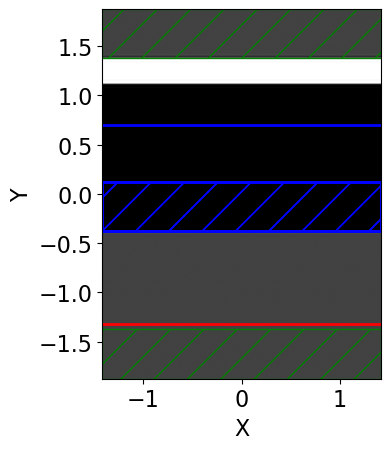

In [59]:
plt.figure()
opt.plot2D(True)
plt.show()

In [60]:
evaluation_history = []
binarization_history = []
cur_iter = [0]

##### 최대화/최소화 대상, Gradient Ascent를 사용하기 때문에 양수로 Return #####
def compute_binarization_degree(rho_flat):
        return np.sum(np.abs(rho_flat-0.5)) / (0.5 * rho_flat.size)

def f(v, gradient, beta):
    print("Current iteration: {}".format(cur_iter[0] + 1))

    f0, dJ_du = opt([mapping(v, eta_i, beta)])

    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, beta, dJ_du
        )  
    
    ##### 이진화 비율 확인 #####
    rho = mapping(v, eta_i, beta)   # (NX*NY,)
    binarization_degree = compute_binarization_degree(rho)
    
    binarization_history.append(binarization_degree)    
    evaluation_history.append(float(np.real(f0)))

    cur_iter[0] = cur_iter[0] + 1
    
    print(f"FOM :{float(np.real(f0))} | Bin Deg : {binarization_degree} | Cur beta : {beta}")
    return float(np.real(f0)) 

In [61]:
algorithm = nlopt.LD_MMA

lb = np.zeros(n_vars)
ub = np.ones(n_vars)

cur_beta = 4.0
beta_scale = 2.0
num_betas = 10
update_factor = 12
bin_thresh = 0.98

for iters in range(num_betas):
    print("current beta:", cur_beta)

    solver = nlopt.opt(algorithm, n_vars)
    solver.set_lower_bounds(lb)
    solver.set_upper_bounds(ub)
    solver.set_max_objective(lambda a, g: f(a, g, cur_beta))
    solver.set_maxeval(update_factor)

    x[:] = solver.optimize(x)

    rho = mapping(x, eta_i, cur_beta)   # <-- 중요: v가 아니라 rho로 평가
    bd = compute_binarization_degree(rho)
    print(f"[beta={cur_beta}] binarization degree (rho) = {bd:.4f}")

    if bd >= bin_thresh:
        rho_bin = np.where(np.array(rho) >= 0.5, 1.0, 0.0).astype(float)
        design_vars.update_weights(rho_bin.reshape(NX, NY))

        print(f"[STOP] binarization degree >= {bin_thresh}. Applied hard binarization and stopped.")
        break

    cur_beta *= beta_scale

current beta: 4.0
Current iteration: 1
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.4778060061986104 | Bin Deg : 0.192850623260374 | Cur beta : 4.0
Current iteration: 2
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.49632135241633807 | Bin Deg : 0.1927367658755699 | Cur beta : 4.0
Current iteration: 3
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.6613748672014008 | Bin Deg : 0.19322156240651392 | Cur beta : 4.0
Current iteration: 4
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.6457392736244262 | Bin Deg : 0.3103923345866105 | Cur beta : 4.0
Current iteration: 5
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.933416765883413 | Bin Deg : 0.20540632699423947 | Cur beta : 4.0
Current iteration: 6
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.928991408597216 | Bin Deg : 0.18618824446628823 | Cur beta : 4.0
Current iteration: 7
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9670920413804481 | Bin Deg : 0.19678554817922067 | Cur beta : 4.0
Current iteration: 8
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.34072209278593757 | Bin Deg : 0.22196184360922422 | Cur beta : 4.0
Current iteration: 9
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9634035067655983 | Bin Deg : 0.19774321200128284 | Cur beta : 4.0
Current iteration: 10
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9681496164855354 | Bin Deg : 0.1970668251988902 | Cur beta : 4.0
Current iteration: 11
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9695397807132645 | Bin Deg : 0.19685642793071578 | Cur beta : 4.0
Current iteration: 12
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9614696383269967 | Bin Deg : 0.20116983099856386 | Cur beta : 4.0
[beta=4.0] binarization degree (rho) = 0.1969
current beta: 8.0
Current iteration: 13
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.8778075240046967 | Bin Deg : 0.360111351437964 | Cur beta : 8.0
Current iteration: 14
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.8921859807555135 | Bin Deg : 0.3604420114913539 | Cur beta : 8.0
Current iteration: 15
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9468720154144932 | Bin Deg : 0.37022613569505125 | Cur beta : 8.0
Current iteration: 16
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.4705922551053148 | Bin Deg : 0.5644031177628381 | Cur beta : 8.0
Current iteration: 17
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9020822290987001 | Bin Deg : 0.4163028229534344 | Cur beta : 8.0
Current iteration: 18
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9692594152074886 | Bin Deg : 0.38397436728483775 | Cur beta : 8.0
Current iteration: 19
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9756704360951912 | Bin Deg : 0.38854502543709574 | Cur beta : 8.0
Current iteration: 20
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.8626517136091988 | Bin Deg : 0.44826149898170126 | Cur beta : 8.0
Current iteration: 21
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9792546694345547 | Bin Deg : 0.39618971274353915 | Cur beta : 8.0
Current iteration: 22
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.97964552792899 | Bin Deg : 0.3981396227962263 | Cur beta : 8.0
Current iteration: 23
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9799564889175403 | Bin Deg : 0.3980882943210174 | Cur beta : 8.0
Current iteration: 24
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9815001948358859 | Bin Deg : 0.3982354155905755 | Cur beta : 8.0
[beta=8.0] binarization degree (rho) = 0.3982
current beta: 16.0
Current iteration: 25
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9199779752072672 | Bin Deg : 0.6277395832493736 | Cur beta : 16.0
Current iteration: 26
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.937121971329415 | Bin Deg : 0.6324121466857289 | Cur beta : 16.0
Current iteration: 27
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9372595472475475 | Bin Deg : 0.6693886944627953 | Cur beta : 16.0
Current iteration: 28
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9350621859178488 | Bin Deg : 0.6630983193546591 | Cur beta : 16.0
Current iteration: 29
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9484957432265765 | Bin Deg : 0.6665177696688659 | Cur beta : 16.0
Current iteration: 30
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.6773456883384745 | Bin Deg : 0.6426333079581068 | Cur beta : 16.0
Current iteration: 31
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9623888752912703 | Bin Deg : 0.6632224596416858 | Cur beta : 16.0
Current iteration: 32
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.788829618169794 | Bin Deg : 0.6375101105549174 | Cur beta : 16.0
Current iteration: 33
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9667930551105691 | Bin Deg : 0.6594714387870901 | Cur beta : 16.0
Current iteration: 34
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9699791525772571 | Bin Deg : 0.6598147600028988 | Cur beta : 16.0
Current iteration: 35
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9422969093335797 | Bin Deg : 0.6456284083326017 | Cur beta : 16.0
Current iteration: 36
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9719332067836394 | Bin Deg : 0.6575869281664903 | Cur beta : 16.0
[beta=16.0] binarization degree (rho) = 0.6576
current beta: 32.0
Current iteration: 37
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.8845835578272021 | Bin Deg : 0.8501982789918479 | Cur beta : 32.0
Current iteration: 38
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.8948597811851635 | Bin Deg : 0.8439880077923875 | Cur beta : 32.0
Current iteration: 39
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.8562636729185764 | Bin Deg : 0.7628274446273786 | Cur beta : 32.0
Current iteration: 40
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9505078025141545 | Bin Deg : 0.8153789993702371 | Cur beta : 32.0
Current iteration: 41
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.16621192039575344 | Bin Deg : 0.8265250776929861 | Cur beta : 32.0
Current iteration: 42
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.8139523679818552 | Bin Deg : 0.8050292985460398 | Cur beta : 32.0
Current iteration: 43
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9576666554473806 | Bin Deg : 0.813268008281185 | Cur beta : 32.0
Current iteration: 44
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9449206049792482 | Bin Deg : 0.772766687516365 | Cur beta : 32.0
Current iteration: 45
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9544967885976962 | Bin Deg : 0.7999638613553797 | Cur beta : 32.0
Current iteration: 46
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9577137343606413 | Bin Deg : 0.8087504935153629 | Cur beta : 32.0
Current iteration: 47
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9581444358097573 | Bin Deg : 0.8070860550710285 | Cur beta : 32.0
Current iteration: 48
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9673001819190853 | Bin Deg : 0.8058558802596176 | Cur beta : 32.0
[beta=32.0] binarization degree (rho) = 0.8059
current beta: 64.0
Current iteration: 49
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.8195768215991652 | Bin Deg : 0.9182338752009052 | Cur beta : 64.0
Current iteration: 50
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.8773071233701824 | Bin Deg : 0.9040799508360821 | Cur beta : 64.0
Current iteration: 51
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.21680413511100616 | Bin Deg : 0.8204877621971114 | Cur beta : 64.0
Current iteration: 52
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9108842864436544 | Bin Deg : 0.8895406713692517 | Cur beta : 64.0
Current iteration: 53
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9382313785485622 | Bin Deg : 0.8811067090460755 | Cur beta : 64.0
Current iteration: 54
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7786090023212155 | Bin Deg : 0.8660342822603644 | Cur beta : 64.0
Current iteration: 55
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.909096767207768 | Bin Deg : 0.8734949350627548 | Cur beta : 64.0
Current iteration: 56
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9232641313038724 | Bin Deg : 0.8784570309964463 | Cur beta : 64.0
Current iteration: 57
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9259283734736133 | Bin Deg : 0.8803503697946193 | Cur beta : 64.0
Current iteration: 58
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9396368607312701 | Bin Deg : 0.8809838760038339 | Cur beta : 64.0
Current iteration: 59
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9352890759824013 | Bin Deg : 0.8789733745427347 | Cur beta : 64.0
Current iteration: 60
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9253313644194018 | Bin Deg : 0.8804515838759053 | Cur beta : 64.0
[beta=64.0] binarization degree (rho) = 0.8810
current beta: 128.0
Current iteration: 61
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.4648603724257603 | Bin Deg : 0.9483814458545888 | Cur beta : 128.0
Current iteration: 62
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.013022707749550257 | Bin Deg : 0.9668537507286558 | Cur beta : 128.0
Current iteration: 63
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.27782716423075215 | Bin Deg : 0.9460741916785629 | Cur beta : 128.0
Current iteration: 64
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.803607161594092 | Bin Deg : 0.8969816206374966 | Cur beta : 128.0
Current iteration: 65
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.8195998852682332 | Bin Deg : 0.8966964730709468 | Cur beta : 128.0
Current iteration: 66
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7814326620242364 | Bin Deg : 0.9025328695722771 | Cur beta : 128.0
Current iteration: 67
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.8283260436999891 | Bin Deg : 0.8975148289283705 | Cur beta : 128.0
Current iteration: 68
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.8263072745767195 | Bin Deg : 0.8969038589378627 | Cur beta : 128.0
Current iteration: 69
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.8319413320023669 | Bin Deg : 0.8973321700932712 | Cur beta : 128.0
Current iteration: 70
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.836542956991233 | Bin Deg : 0.8989483279476101 | Cur beta : 128.0
Current iteration: 71
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.8589120444551469 | Bin Deg : 0.9000074563554222 | Cur beta : 128.0
Current iteration: 72
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.4911044842252525 | Bin Deg : 0.8981579252376436 | Cur beta : 128.0
[beta=128.0] binarization degree (rho) = 0.9000
current beta: 256.0
Current iteration: 73
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.8596936359635028 | Bin Deg : 0.9484103857976314 | Cur beta : 256.0
Current iteration: 74
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.881962753386345 | Bin Deg : 0.9620997712936613 | Cur beta : 256.0
Current iteration: 75
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9224101609202912 | Bin Deg : 0.9628233633652973 | Cur beta : 256.0
Current iteration: 76
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.596794451466903 | Bin Deg : 0.961637134165612 | Cur beta : 256.0
Current iteration: 77
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9073922566779077 | Bin Deg : 0.964153348919739 | Cur beta : 256.0
Current iteration: 78
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9178601581114366 | Bin Deg : 0.9629625016112485 | Cur beta : 256.0
Current iteration: 79
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9228931431436393 | Bin Deg : 0.9628659470322459 | Cur beta : 256.0
Current iteration: 80
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9179704155407786 | Bin Deg : 0.9629147449425511 | Cur beta : 256.0
Current iteration: 81
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9181327991193248 | Bin Deg : 0.9628713306855524 | Cur beta : 256.0
Current iteration: 82
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9228966079368017 | Bin Deg : 0.9628664904430053 | Cur beta : 256.0
Current iteration: 83
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9228988327105515 | Bin Deg : 0.9628668384933624 | Cur beta : 256.0
Current iteration: 84
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9229002617402687 | Bin Deg : 0.9628670616930886 | Cur beta : 256.0
[beta=256.0] binarization degree (rho) = 0.9629
current beta: 512.0
Current iteration: 85
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9175798462628949 | Bin Deg : 0.98083428364436 | Cur beta : 512.0
Current iteration: 86
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.7627509058004981 | Bin Deg : 0.982478067114281 | Cur beta : 512.0
Current iteration: 87
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9252833968289285 | Bin Deg : 0.9791196249843167 | Cur beta : 512.0
Current iteration: 88
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9341951604239056 | Bin Deg : 0.9788839858536151 | Cur beta : 512.0
Current iteration: 89
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9319197521850809 | Bin Deg : 0.9818047132147849 | Cur beta : 512.0
Current iteration: 90
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9347080121362149 | Bin Deg : 0.9838287310097201 | Cur beta : 512.0
Current iteration: 91
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.8969698196090014 | Bin Deg : 0.9799990541012112 | Cur beta : 512.0
Current iteration: 92
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9462501662438898 | Bin Deg : 0.9835040893737855 | Cur beta : 512.0
Current iteration: 93
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9460732697122508 | Bin Deg : 0.9840582467942871 | Cur beta : 512.0
Current iteration: 94
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.944989783047092 | Bin Deg : 0.9837469993284215 | Cur beta : 512.0
Current iteration: 95
Starting forward run...
Starting adjoint run...


Calculating gradient...
FOM :0.9468353305531513 | Bin Deg : 0.9835937504285144 | Cur beta : 512.0
Current iteration: 96
Starting forward run...
Starting adjoint run...
Calculating gradient...
FOM :0.9472413411419456 | Bin Deg : 0.9836574041117213 | Cur beta : 512.0
[beta=512.0] binarization degree (rho) = 0.9837
[STOP] binarization degree >= 0.98. Applied hard binarization and stopped.


AttributeError: 'IndexedSource' object has no attribute 'center'

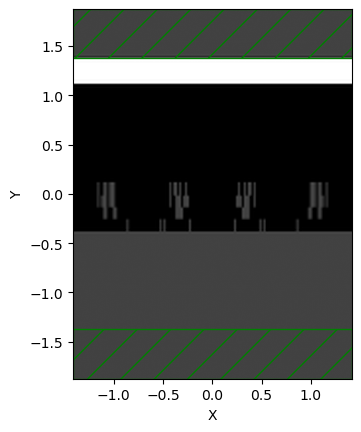

In [17]:
opt.plot2D()

In [18]:
np.savetxt("weights_MMA_grat3", design_vars.weights)

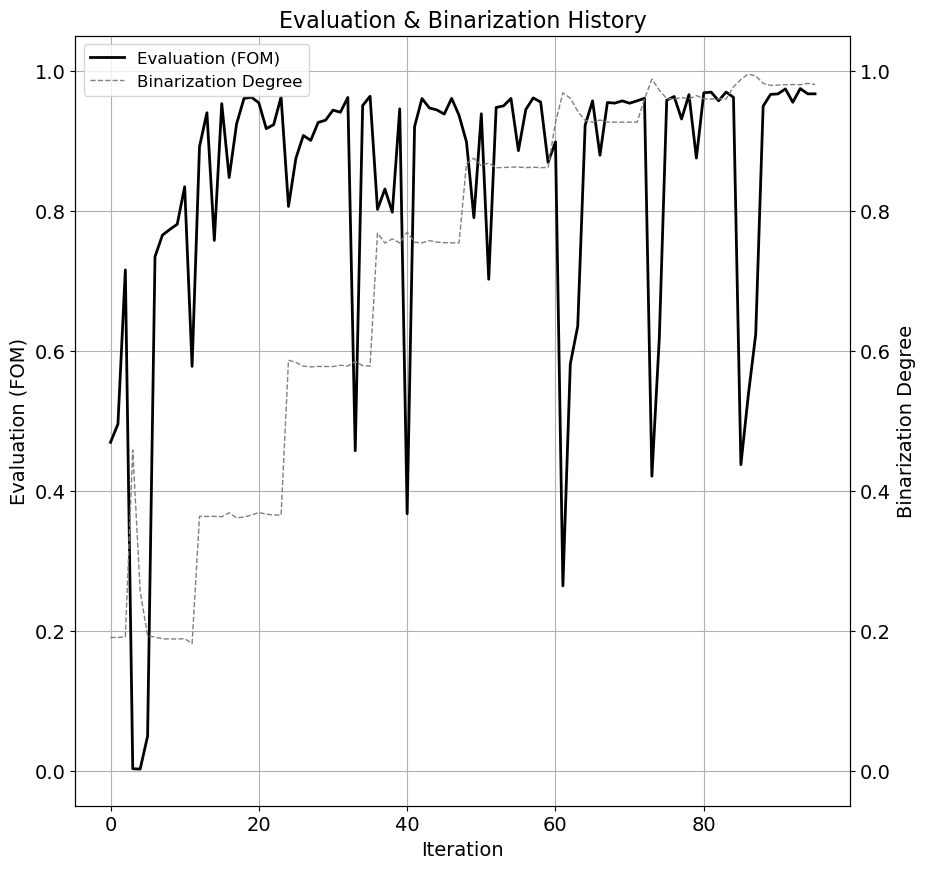

In [19]:
fig, ax1 = plt.subplots(figsize=(10, 10))

# Title
ax1.set_title("Evaluation & Binarization History", fontsize=16)

# Left y-axis: Evaluation (검정 실선)
ax1.plot(evaluation_history, color="k", linewidth=2, label="Evaluation (FOM)")
ax1.set_xlabel("Iteration", fontsize=14)
ax1.set_ylabel("Evaluation (FOM)", fontsize=14)
ax1.tick_params(axis="both", labelsize=14)
ax1.set_ylim(-0.05,top = 1.05)

# Right y-axis: Binarization (회색 얇은 점선)
ax2 = ax1.twinx()
ax2.plot(binarization_history, color="0.5", linestyle="--", linewidth=1, label="Binarization Degree")
ax2.set_ylabel("Binarization Degree", fontsize=14)
ax2.tick_params(axis="y", labelsize=14)
ax2.set_ylim(-0.05, 1.05)

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=12, loc="best")

ax1.grid(True)
plt.show()


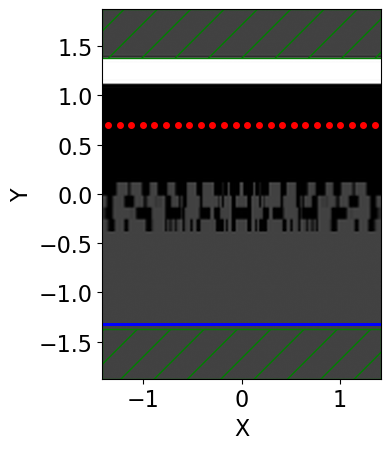

In [54]:
import math, os
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product
import meep as mp
import meep.adjoint as mpa
from meep.materials import Ag
import matplotlib.pyplot as plt

mp.verbosity(0)
resolution = 50      # px/µm

lambda0 = 0.5            # [um]
fcen    = 1.0 / lambda0  # [1/um]
width = 0.1
fwidth = fcen*width

nfreq   = 1
frequencies = [fcen]

dpml = 0.5
dair = 1.0
hrod = 0.5     

dsub = 1.0
dAg  = 0.25

sx = 2.121                          # +-3차가 +-45도 나옴
sx = 2.828                          # +-4차가 +-45도 나옴
sy = dpml + dair + hrod + dsub + dAg + dpml
cell_size = mp.Vector3(sx, sy)

wrod = sx

Medium1 = mp.Medium(index = 2.0)
Medium2 = mp.Medium(index = 1.0)

pml_layers = [
    mp.PML(direction=mp.Y, thickness=dpml, side=mp.High),
    mp.PML(direction=mp.Y, thickness=dpml, side=mp.Low)
]

DESIGN_W  = wrod
DESIGN_H  = hrod
design_c  = mp.Vector3(0, 0.5*sy - dpml - dAg - dsub - 0.5*hrod)
design_sz = mp.Vector3(DESIGN_W, DESIGN_H)

design_res = resolution
NX = int(DESIGN_W * design_res) + 1


DESIGN_MODE = 'grating'  # or 'free' or 'grating'

if DESIGN_MODE == 'free':
    DESIRED_LAYERS = 1
    NY = int(round(DESIGN_H * design_res)) + 1
else:
    # 해상도와 레이어-패딩 조건을 동시에 만족
    DESIRED_LAYERS = 4       # 원하는 레이어 수 (패딩 1픽셀씩 자동)
    NY_min_layers = 2 * DESIRED_LAYERS - 1        # 레이어 L개 + 패딩 L-1개
    NY_res       = int(round(DESIGN_H * design_res))
    NY = max(NY_res, NY_min_layers)

n_vars = NX * NY

# 최소 피쳐/이진화 설정
MIN_FEATURE = 0.09    # ~80 nm
eta_i = 0.55
beta  = 8
beta_scale = 2
num_beta_steps = 3
filter_radius = mpa.get_conic_radius_from_eta_e(MIN_FEATURE, eta_i)

# x = np.ones((n_vars,), dtype=float) * 0.5
np.random.seed(42)

x = np.random.rand(n_vars) * 0.2 + 0.4

design_vars = mp.MaterialGrid(
    mp.Vector3(NX, NY, 0),
    Medium1, Medium2,
    grid_type="U_MEAN",
)
design_region = mpa.DesignRegion(design_vars, volume=mp.Volume(center=design_c, size=design_sz))

# ----------------------------
# geometry (디자인 포함)
# ----------------------------
geometry = [
    mp.Block(
        material=Ag,
        center=mp.Vector3(0, 0.5*sy - dpml - 0.5*dAg),
        size=mp.Vector3(mp.inf, dAg, mp.inf),
    ),
    # Medium1 bulk (Ag 아래에 위치)
    mp.Block(
        material=Medium1,
        center=mp.Vector3(0, 0.5*sy - dpml - dAg - 0.5*dsub),
        size=mp.Vector3(mp.inf, dsub, mp.inf),
    ),
    # Design block (텍스처 영역)
    mp.Block(
        material=design_vars,
        center=design_region.center,
        size=design_region.size,
    ),
]

src_center_pos = float(0.5*sy - dpml - dAg - dsub - 0.5*hrod+1.5)
src_size   = mp.Vector3(0, 0, 0)

num_sources = 24

src_time_object = mp.GaussianSource(frequency=fcen, fwidth=fwidth, is_integrated=True)
src_component = mp.Ez
# 소스들의 y, z 좌표 기준값 설정
# src_base_center = mp.Vector3(0,src_center_pos,0)
src_base_center = mp.Vector3(0,0.7,0)
src_base_size = mp.Vector3(0, 0, 0)

# --- for loop를 사용하여 소스 리스트 직접 생성 ---
sources = []
if num_sources == 1:
    # 소스가 하나일 경우, 중앙(x=0)에 배치
    center = mp.Vector3(0, src_base_center.y, src_base_center.z)
    sources.append(
        mp.Source(
            src=src_time_object,
            component=src_component,
            center=center,
            size=src_base_size
        )
    )
elif num_sources > 1:
    # 소스 간의 간격(주기) 계산
    period = sx / num_sources
    # 첫 번째 소스의 위치 계산 (전체 배열이 중앙에 오도록)
    start_x = -sx / 2 + period / 2
    
    for i in range(num_sources):
        # 현재 소스의 x 좌표 계산
        x_pos = start_x + i * period
        center = mp.Vector3(x_pos, src_base_center.y, src_base_center.z)
        
        # 계산된 위치에 새로운 소스 객체를 생성하여 리스트에 추가
        sources.append(
            mp.Source(
                src=src_time_object,
                component=src_component,
                center=center,
                size=src_base_size
            )
        )

sim = mp.Simulation(
    cell_size=cell_size,
    resolution=resolution,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    k_point = mp.Vector3(0,0,0),
    extra_materials=[Ag]
)

bottom_pml_top_y = -0.5 * sy + dpml
tmon_center = mp.Vector3(0, bottom_pml_top_y + (3 / resolution))
tmon_size   = mp.Vector3(sx, 0, 0)                # x방향 한 주기 = sx

k = np.loadtxt("/home/min/LGD_Share/LGD_Mode_Decomposition_Share/weights_MMA_grat3")
k = np.loadtxt("/home/min/LGD_Share/LGD_Mode_Decomposition_Share/weights_adam")
design_vars.update_weights(k)

dft_t = sim.add_dft_fields([mp.Ez], fcen, 0, 1, center=tmon_center, size=tmon_size)
flux = sim.add_flux(fcen,          # 중심 주파수
                        0,             # 대역폭 df=0 → 단일 주파수
                        1,             # 샘플 수 1개
                        mp.FluxRegion(center=tmon_center,
                                      size=tmon_size))  # 라인 법선이 +y

plt.figure()
sim.plot2D()
plt.show()

<Axes: xlabel='X', ylabel='Y'>

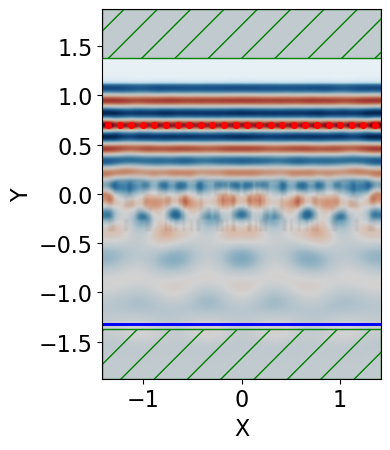

In [53]:
sim.run(until = 1)
sim.plot2D(fields = mp.Ez)

In [55]:
sim.run(until_after_sources=mp.stop_when_dft_decayed(1e-3))

In [56]:
# ===== 유틸: kx 인덱스/값 라벨 + 퍼센트 표시 =====
def annotate_kx_points(ax, kx_vec, y_vec, kx_marks, labels=None,
                       as_index=True,              # True: 인덱스, False: kx 값
                       dy_pts=(-10, -10),
                       show_marker=True,
                       show_percent=False,         # (추가) 퍼센트 표시 여부
                       fft_complex=None,           # (추가) 원본 복소 FFT (있으면 여기서 % 계산)
                       percent_ref=None):          # (추가) 분모(총 전력) override 가능
    """
    - show_percent=True 이고 fft_complex가 주어지면: 각 지점 % = |FFT|^2 / sum(|FFT|^2) * 100
    - show_percent=True 이고 fft_complex가 None이면: y_vec 자체가 이미 [%] 라고 가정
    """
    kx_marks = np.atleast_1d(kx_marks)
    if labels is None:
        labels = [f"kx[{m}]" if as_index else f"kx={m:.3f}" for m in kx_marks]

    # 표시할 인덱스 선택
    idx_list = []
    if as_index:
        for m in kx_marks:
            i = int(np.clip(int(m), 0, len(kx_vec)-1))
            idx_list.append(i)
    else:
        for kv in kx_marks:
            i = int(np.argmin(np.abs(kx_vec - kv)))
            idx_list.append(i)

    # 퍼센트 계산 준비
    if show_percent and (fft_complex is not None):
        # |FFT|^2 기준 총전력
        total_power = np.sum(np.abs(fft_complex)**2) if percent_ref is None else float(percent_ref)

    # 표시 루프
    for i, lab in zip(idx_list, labels):
        x_pt = kx_vec[i]; y_pt = y_vec[i]
        if show_marker:
            ax.scatter([x_pt], [y_pt], s=80, marker='o')

        # 퍼센트 문자열
        if show_percent:
            if fft_complex is not None:
                p_i = np.abs(fft_complex[i])**2
                pct = 100.0 * p_i / (total_power + 1e-30)
            else:
                pct = float(y_pt)  # y_vec이 이미 [%]라고 가정
            lab_full = f"{lab} ({pct:.2f}%)"
        else:
            lab_full = lab

        ax.annotate(lab_full,
                    xy=(x_pt, y_pt),
                    xytext=dy_pts, textcoords="offset points",
                    ha='right', va='top', fontsize=16)

    return idx_list

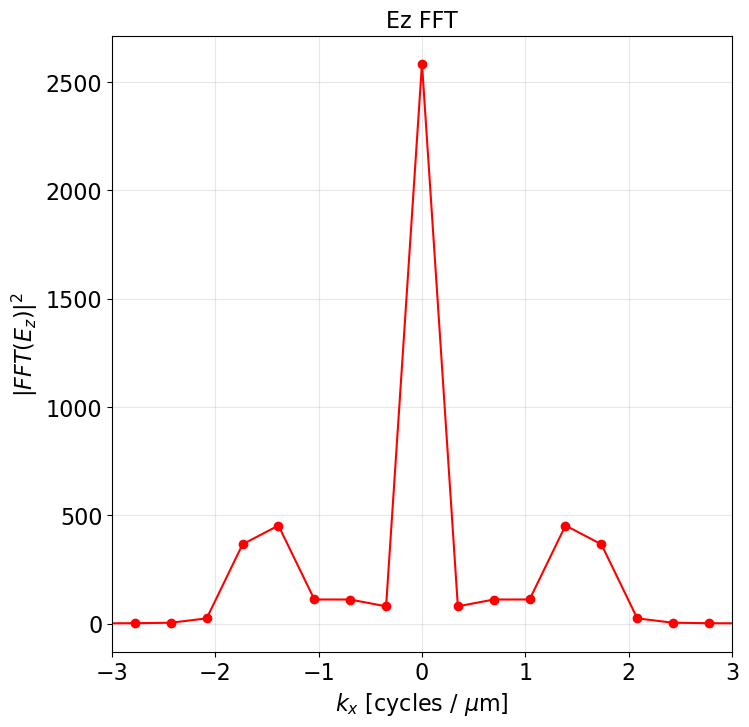

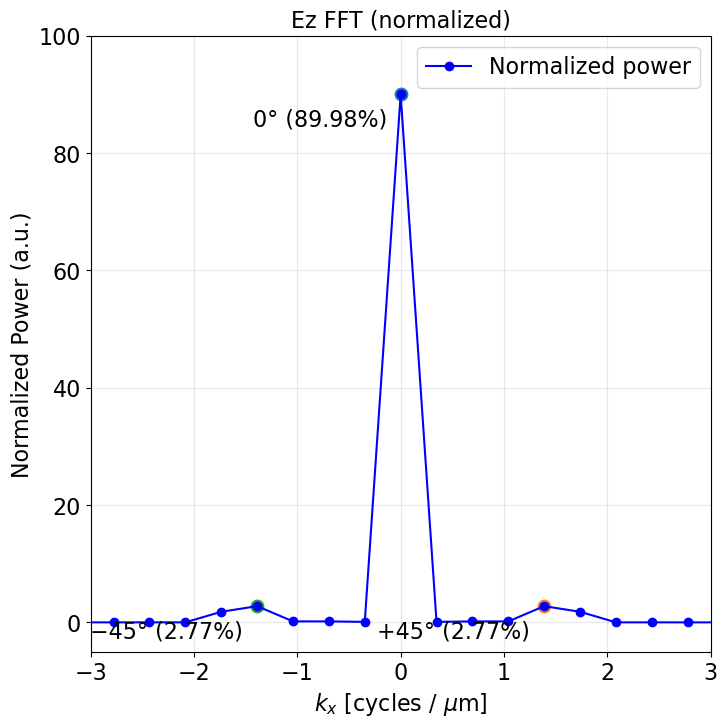

In [57]:
import matplotlib as mpl
mpl.rcParams.update({
    "axes.titlesize": 16,
    "axes.labelsize": 16,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 16
})

Ez_line = np.squeeze(np.array(sim.get_dft_array(dft_t, mp.Ez, 0))).ravel()  # 기존 Ez_line 유지, 1D 보장
fft_Ez  = np.fft.fftshift(np.fft.fft(Ez_line))  # 기존 변수명 유지
kx = np.fft.fftshift(np.fft.fftfreq(len(fft_Ez), d = 1/resolution))

# 찍을 인덱스들 (0, +4, -4 bin)
kx_indices_to_mark = [np.argmin(np.abs(kx)), np.argmin(np.abs(kx))+4, np.argmin(np.abs(kx))-4]
labels_idx = ["0 bin", "+45° bin(+4)", "−45° bin(−4)"]

plt.figure(figsize=(8,8))
plt.plot(kx, np.abs(fft_Ez),'ro-')
ax1 = plt.gca()

plt.xlabel(r"$k_x$ [cycles / $\mu$m]")
plt.ylabel(r"$|FFT(E_z)|^2$")
plt.title("Ez FFT")
plt.grid(True, which="both", alpha=0.3)
plt.xlim(-3,3)
plt.show()

# kx 값으로 직접 지정해도 됨 (as_index=False)
kx_values_to_mark = [0.0, +1.414, -1.414]
labels_val = ["0°", "+45°", "−45°"]

############ 정규화 버전 ############
total_power = np.sum(np.abs(fft_Ez)**2)
normal_fft_Ez = (np.abs(fft_Ez)**2) / (total_power) * 100  # [%]

plt.figure(figsize=(8,8))
plt.plot(kx, normal_fft_Ez, 'bo-', label="Normalized power")
ax2 = plt.gca()

_ = annotate_kx_points(ax2, kx, normal_fft_Ez, kx_values_to_mark,
                       labels=labels_val,
                       as_index=False,          # ← kx 값으로 매칭
                       dy_pts=(-10,-10),
                       show_marker=True,
                       show_percent=True,       # ← 퍼센트 표시 ON
                       fft_complex=None)        # ← y가 이미 [%]이므로 생략

plt.xlabel(r"$k_x$ [cycles / $\mu$m]")
plt.ylabel(r"Normalized Power (a.u.)")
plt.title("Ez FFT (normalized)")
plt.xlim(-3, 3)
plt.ylim(-5, 100)
plt.grid(True, which="both", alpha=0.3)
plt.legend(loc="best")
plt.show()


In [552]:
import numpy as np
import math

def extract_real_sinusoid_from_fft(Ez_line, resolution, kx_target_list, sx=None):
    """
    Ez_line: (N,) 샘플된 Ez(x) (복소 가능)
    kx_target_list: cycles/um 단위의 타겟 kx들. 예) [0.0, +1.414, -1.414]
    resolution: px/um (지금 너가 fftfreq에 d=1/resolution 쓰고 있으니 동일 기준 유지)
    sx: (선택) 주기 길이. 주면 x축도 같이 만들어서 LS 피팅과 비교 가능

    반환: 각 kx_target별로 (idx, kx_bin, C_complex, Acos, Asin, Aamp, phase)
    """

    Ez = np.asarray(Ez_line).ravel()
    N = Ez.size

    # FFT (shift 포함) / 주파수 축(kx, cycles/um)
    F = np.fft.fftshift(np.fft.fft(Ez))
    kx = np.fft.fftshift(np.fft.fftfreq(N, d=1.0 / float(resolution)))

    out = []

    for kx_t in kx_target_list:
        idx = int(np.argmin(np.abs(kx - kx_t)))
        kx_bin = float(kx[idx])

        # 복소 푸리에 계수 (np.fft.fft는 정규화 없음)
        # 시간영역(공간)으로 재구성되는 계수는 C = F/N
        C = F[idx] / N

        # 실수 파형 Re(Ez)에 대한 cos/sin 계수로 해석:
        # Re( C e^{i2πkx x} ) = Re(C)*cos(2πkx x) - Im(C)*sin(2πkx x)
        # 따라서
        Acos = 2.0 * np.real(C)   # 양의 주파수 성분일 때 (kx>0) 대칭 성분을 합친 cos 진폭
        Asin = -2.0 * np.imag(C)  # sin 진폭
        Aamp = math.sqrt(float(Acos**2 + Asin**2))  # 실수 사인파 총 진폭
        phase = math.atan2(float(-Asin), float(Acos))  # cos(·+phi) 형태의 phi (정의 일관용)

        out.append({
            "kx_target": float(kx_t),
            "idx": idx,
            "kx_bin": kx_bin,
            "C_complex": C,
            "Acos": float(Acos),
            "Asin": float(Asin),
            "Aamp": float(Aamp),
            "phase_rad": float(phase),
        })

    return out


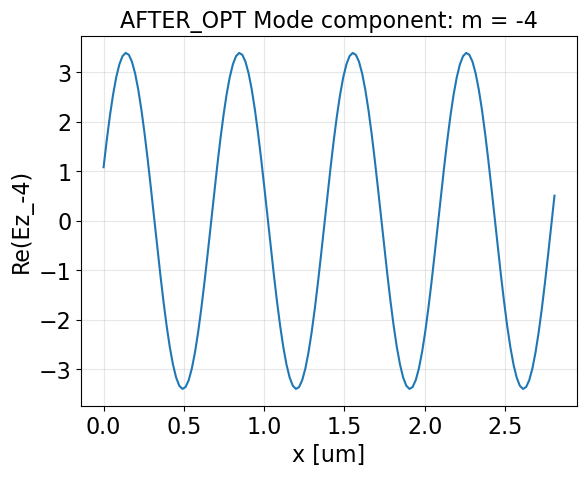

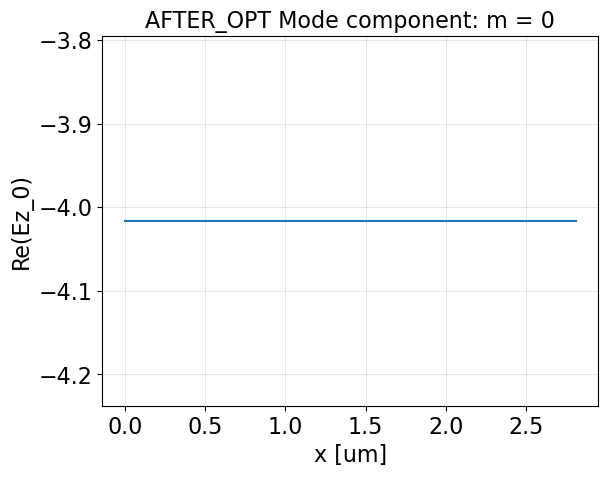

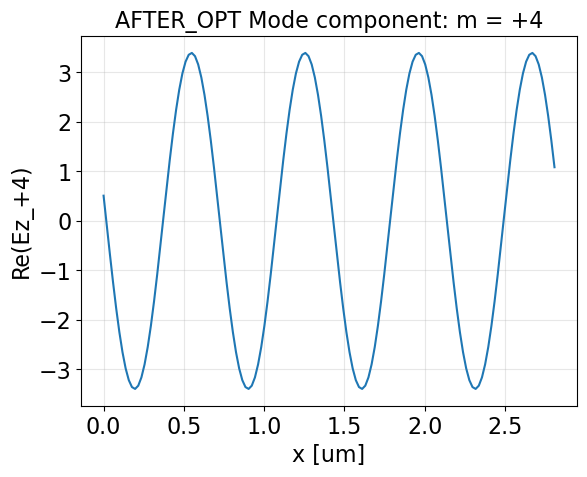

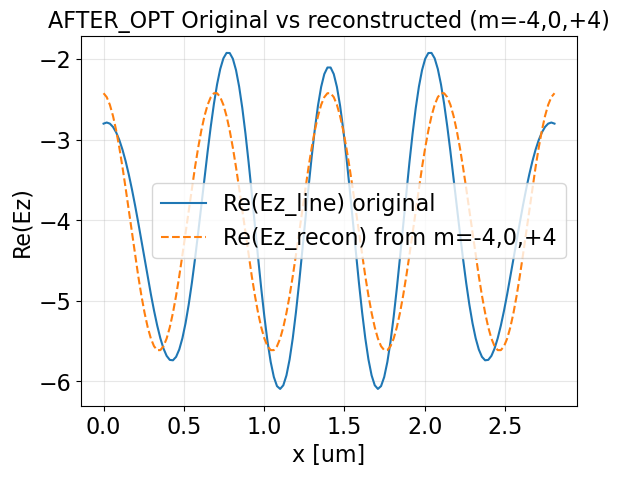


[AFTER_OPT] Extracted complex coeffs:
C(-4) = (1.0849640208577866+3.2172017828028636j)
C( 0) = (-4.016451934693999-9.185626638237228j)
C(+4) = (0.5098197527095149+3.3567272837650997j)
[AFTER_OPT] Intensity ratios within m=-4,0,+4 (|C|^2 normalized): (0.09329300059166991, 0.8134139988166601, 0.09329300059166988)


In [1018]:
import numpy as np
import matplotlib.pyplot as plt
import meep as mp

def decompose_modes_from_line(Ez_line, sx, m_order, resolution=None):
    """
    Ez_line: 모니터 라인에서 얻은 복소 Ez(x) 샘플 (1D)
    sx     : 주기 길이 [um]
    m_order: 회절차수 (예: 4)

    반환:
      x, Ez_m4, Ez_0, Ez_p4, Ez_recon, (C_m4, C0, C_p4)
    """
    Ez_line = np.asarray(Ez_line).ravel()

    # (권장) 끝점 중복 제거: 길이가 sx*resolution+1이면 마지막 점 제거
    if resolution is not None:
        N_expected = int(round(sx * float(resolution))) + 1
        if Ez_line.size == N_expected:
            Ez_line = Ez_line[:-1]

    N = Ez_line.size
    x = np.linspace(0.0, sx, N, endpoint=False)

    # ---- 푸리에 계수 추출(투영) ----
    # C0  = (1/N) Σ Ez
    # Cp4 = (1/N) Σ Ez * exp(-i2π m x/sx)   ( +m 성분 계수 )
    # Cm4 = (1/N) Σ Ez * exp(+i2π m x/sx)   ( -m 성분 계수 )
    C0  = np.mean(Ez_line)
    Cp4 = np.mean(Ez_line * np.exp(-1j * 2.0 * np.pi * m_order * x / sx))
    Cm4 = np.mean(Ez_line * np.exp(+1j * 2.0 * np.pi * m_order * x / sx))

    # ---- 각 모드 파형 재구성 ----
    Ez_0  = C0  * np.ones_like(x, dtype=np.complex128)
    Ez_p4 = Cp4 * np.exp(+1j * 2.0 * np.pi * m_order * x / sx)
    Ez_m4 = Cm4 * np.exp(-1j * 2.0 * np.pi * m_order * x / sx)

    Ez_recon = Ez_m4 + Ez_0 + Ez_p4

    return x, Ez_m4, Ez_0, Ez_p4, Ez_recon, (Cm4, C0, Cp4)


def plot_mode_waveforms(Ez_line, sx, m_order=4, resolution=None, title_prefix="AFTER"):
    """
    합성 예제처럼 m=-4,0,+4의 Re() 파형을 각각 플롯 + (원 신호 vs 재구성) 비교 플롯
    """
    x, Ez_m4, Ez_0, Ez_p4, Ez_rec, (Cm4, C0, Cp4) = decompose_modes_from_line(
        Ez_line, sx=sx, m_order=m_order, resolution=resolution
    )

    # ---- 각 모드 파형 플롯 ----
    plt.figure()
    plt.plot(x, np.real(Ez_m4))
    plt.xlabel("x [um]")
    plt.ylabel("Re(Ez_-4)")
    plt.title(f"{title_prefix} Mode component: m = -{m_order}")
    plt.grid(True, alpha=0.3)
    plt.show()

    plt.figure()
    plt.plot(x, np.real(Ez_0))
    plt.xlabel("x [um]")
    plt.ylabel("Re(Ez_0)")
    plt.title(f"{title_prefix} Mode component: m = 0")
    plt.grid(True, alpha=0.3)
    plt.show()

    plt.figure()
    plt.plot(x, np.real(Ez_p4))
    plt.xlabel("x [um]")
    plt.ylabel("Re(Ez_+4)")
    plt.title(f"{title_prefix} Mode component: m = +{m_order}")
    plt.grid(True, alpha=0.3)
    plt.show()

    # ---- 원 신호 vs (m=-4,0,+4만) 재구성 비교 ----
    plt.figure()
    plt.plot(x, np.real(Ez_line[:len(x)]), label="Re(Ez_line) original")
    plt.plot(x, np.real(Ez_rec), "--", label="Re(Ez_recon) from m=-4,0,+4")
    plt.xlabel("x [um]")
    plt.ylabel("Re(Ez)")
    plt.title(f"{title_prefix} Original vs reconstructed (m=-4,0,+4)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    # ---- 계수(복소)와 간단한 intensity 비율 출력 ----
    I_m4 = np.abs(Cm4)**2
    I_0  = np.abs(C0 )**2
    I_p4 = np.abs(Cp4)**2
    It = I_m4 + I_0 + I_p4 + 1e-30
    print(f"\n[{title_prefix}] Extracted complex coeffs:")
    print("C(-4) =", Cm4)
    print("C( 0) =", C0)
    print("C(+4) =", Cp4)
    print(f"[{title_prefix}] Intensity ratios within m=-4,0,+4 (|C|^2 normalized):",
          (I_m4/It, I_0/It, I_p4/It))


# =========================
# 사용 예시 (최적화 '이후' 시뮬에서)
# =========================
# dft_t는 네가 add_dft_fields로 만든 모니터 핸들
Ez_line_after = np.squeeze(np.array(sim.get_dft_array(dft_t, mp.Ez, 0))).ravel()

plot_mode_waveforms(
    Ez_line_after,
    sx=sx,
    m_order=4,
    resolution=resolution,      # 끝점 중복 제거에 사용
    title_prefix="AFTER_OPT"
)

# =========================
# (옵션) 최적화 '이전' 값도 저장해뒀다면 비교 가능
# =========================
# Ez_line_before = ... (최적화 시작 전에 저장한 Ez_line)
# plot_mode_waveforms(Ez_line_before, sx=sx, m_order=4, resolution=resolution, title_prefix="BEFORE_OPT")


In [684]:
Ez_line = np.squeeze(np.array(sim.get_dft_array(dft_t, mp.Ez, 0))).ravel()  # 1D 보장
fft_Ez  = np.fft.fftshift(np.fft.fft(Ez_line))
kx      = np.fft.fftshift(np.fft.fftfreq(len(fft_Ez), d=1/resolution))

# 0 bin 인덱스
i0 = int(np.argmin(np.abs(kx)))

# -4, 0, +4 bin 인덱스
idx_m4 = i0 - 4
idx_0  = i0
idx_p4 = i0 + 4

# 범위 체크(안전)
N = len(fft_Ez)
if not (0 <= idx_m4 < N and 0 <= idx_p4 < N):
    raise IndexError("±4 bin 인덱스가 FFT 범위를 벗어났습니다. (샘플 수/shift 확인 필요)")

# 값(복소수, 크기) 출력
print("m=-4 index:", idx_m4, "kx:", kx[idx_m4], "FFT:", fft_Ez[idx_m4], "|FFT|:", np.abs(fft_Ez[idx_m4]))
print("m= 0 index:", idx_0,  "kx:", kx[idx_0],  "FFT:", fft_Ez[idx_0],  "|FFT|:", np.abs(fft_Ez[idx_0]))
print("m=+4 index:", idx_p4, "kx:", kx[idx_p4], "FFT:", fft_Ez[idx_p4], "|FFT|:", np.abs(fft_Ez[idx_p4]))


m=-4 index: 68 kx: -1.3888888888888888 FFT: (517.3321986864195+37.02405267088308j) |FFT|: 518.6553617518105
m= 0 index: 72 kx: 0.0 FFT: (-1153.6899719270084-870.6691993521316j) |FFT|: 1445.3599572512805
m=+4 index: 76 kx: 1.3888888888888888 FFT: (503.04360087309465+126.29536766854204j) |FFT|: 518.6553617518107
